## <a name="abstract">Titanic Machine Learning From Disaster</a>

Abstract The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [150]:
using DataFrames
using ColorBrewer
using XGBoost
using Gadfly

## Load Preprocessed Data

In [3]:
train = readtable("./data/train_enriched.tsv", separator='\t')
test = readtable("./data/test_enriched.tsv", separator='\t');

In [7]:
features = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked,
            :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily,
            :CabinPrefix, :CabinNumber]
label = :Survived;

In [9]:
train_x = Array{Float64}(train[:, features])
train_y = Array{Float64}(train[:, label])
test_x = Array{Float64}(test[:, features]);

## Training

In [246]:
greens = palette("Greens", 9)
blues = palette("Blues", 9)

function sample_train_val(data, features, label, split_p=.8)
    nrows = size(data, 1)
    split_size = round(Int, nrows*split_p)
    sample_index = shuffle(collect(1:nrows))
    train_x = Array{Float64}(data[sample_index[1:split_size], features])
    train_y = Array{Float64}(data[sample_index[1:split_size], label])
    val_x = Array{Float64}(data[sample_index[split_size+1:end], features])
    val_y = Array{Float64}(data[sample_index[split_size+1:end], label])
    return train_x, train_y, val_x, val_y
end

binarize{T <: Number}(y::Array{T,1}) = Array{Int8,1}(y .>= .5)
function calc_accuracy{T <: Number, N <: Number}(yreal::Array{T,1}, ypred::Array{N,1})
    nrows = length(yreal)
    preds_diff = map(i -> yreal[i] == (ypred[i] >= .5? 1:0), vcat(1:nrows))
    return round(sum(preds_diff)/nrows, 2)  
end

function train_gb(X, Y, num_round, params; show_training_time=true)
    show_training_time && tic() 
    model = XGBoost.xgboost(X, num_round, label=Y, param=params)
    show_training_time && toc()
    return model
end

function train_eval_gb(TX, TY, VX, VY, num_round, params; show_training_time=true)
    model = train_gb(TX, TY, num_round, params, show_training_time=show_training_time)
    ypred_train = XGBoost.predict(model, TX)
    ypred_val = XGBoost.predict(model, VX)
    acc_train = calc_accuracy(TY, ypred_train)
    acc_val = calc_accuracy(VY, ypred_val)
    return model, acc_train, acc_val
end

function tunning_param_ntimes(data, features, label, num_rounds, params, 
                              key, values, ntimes)
    accs_trains = Array[]
    accs_vals = Array[]
    for n=1:ntimes
        _, accs_train, accs_val = tunning_param(sample_train_val(data, features, label)...,
                                                num_rounds, params, key, values, 
                                                show_training_time=false)
        push!(accs_trains, accs_train)
        push!(accs_vals, accs_val)
    end
    plot_multi_tunning(key, values, accs_trains, accs_vals)
end

function tunning_param(TX, TY, VX, VY, num_round, params, key, values; 
                       show_training_time=true)
    models = []
    accs_train = []
    accs_val = []
    params_tunning = copy(params)
    
    for value in values
        params_tunning[key] = value
        model, acc_train, acc_val = train_eval_gb(TX, TY, VX, VY, num_round,
                                                  params_tunning,
                                                  show_training_time=show_training_time)
        push!(models, model)
        push!(accs_train, acc_train)
        push!(accs_val, acc_val)
    end
    return models, accs_train, accs_val
end

function plot_tunning(key, values, accs_train, accs_val)
    set_default_plot_size(1000px, 500px)
    plot(
        layer(x=values, y=accs_train, Geom.line, Geom.point, 
              Theme(default_color=colorant"lightgreen", line_width=2px)),
        layer(x=values, y=accs_val, Geom.line, Geom.point, 
              Theme(default_color=colorant"deepskyblue", line_width=2px)),
        Scale.x_discrete, Guide.xlabel(key), Guide.ylabel("Acc"), 
        Guide.title("Parameter Tunning"), 
        Guide.manual_color_key("Legend", ["Tra", "Val"], ["lightgreen", "deepskyblue"])
    )
end

function plot_multi_tunning(key, values, accs_trains, accs_vals)
    set_default_plot_size(1000px, 600px)
    
    layers = [layer(x=values, y=accs, Geom.line, Geom.point, 
                    Theme(default_color=greens[3], line_width=2px)) 
                    for accs in accs_trains]
    
    append!(layers, [layer(x=values, y=accs, Geom.line, Geom.point, 
                           Theme(default_color=blues[3], line_width=2px)) 
                     for accs in accs_vals])
    
    avg_train = reshape(vcat(accs_trains...), (length(accs_trains[1]), size(accs_trains, 1)))
    avg_train = map(i -> mean(avg_train[i, :]), vcat(1:size(avg_train, 1)))
    
    avg_val = reshape(vcat(accs_vals...), (length(accs_vals[1]), size(accs_vals, 1)))
    avg_val = map(i -> mean(avg_val[i, :]), vcat(1:size(avg_val, 1)))
    
    unshift!(layers, layer(x=values, y=avg_train, Geom.line, Geom.point, 
                           Theme(default_color=greens[6], line_width=4px)))
    
    unshift!(layers, layer(x=values, y=avg_val, Geom.line, Geom.point, 
                           Theme(default_color=blues[6], line_width=4px)))
    
    plot(layers..., Scale.x_discrete, Guide.xlabel(key), Guide.ylabel("Acc"), 
    Guide.title("Parameter Tunning"), Guide.manual_color_key("Phase", 
        ["Training", "Validation"], [greens[6], blues[6]]))
end

plot_multi_tunning (generic function with 1 method)

In [49]:
num_round = 10
params = Dict({"max_depth"=>6, "eta"=> .3, "subsample" => .5, "objective"=>"binary:logistic"})
model = train_gb(train_x, train_y, num_round, params)
ypred = XGBoost.predict(model, train_x)
ypred_submission = binarize(XGBoost.predict(model, test_x));


Use "Dict{Any,Any}(a=>b, ...)" instead.
[1]	train-error:0.157127
[2]	train-error:0.142536


elapsed time: 0.

[3]	train-error:0.139169
[4]	train-error:0.131313
[5]	train-error:0.120090
[6]	train-error:0.132435
[7]	train-error:0.126824
[8]	train-error:0.121212
[9]	train-error:0.113356
[10]	train-error:0.112233


017558877 seconds


In [50]:
calc_accuracy(train_y, ypred)

0.89

## Tunning Parameters

### Max Depth

[1]	train-error:0.213184
[2]	train-error:0.200561
[3]	train-error:0.200561
[4]	train-error:0.200561
[5]	train-error:0.193548
[6]	train-error:0.193548
[7]	train-error:0.193548
[8]	train-error:0.193548
[9]	train-error:0.171108
[10]	train-error:0.171108
[1]	train-error:0.214586
[2]	train-error:0.175316
[3]	train-error:0.168303
[4]	train-error:0.162693
[5]	train-error:0.164095
[6]	train-error:0.162693
[7]	train-error:0.154278
[8]	train-error:0.152875
[9]	train-error:0.154278
[10]	train-error:0.148668
[1]	train-error:0.171108
[2]	train-error:0.164095
[3]	train-error:0.159888
[4]	train-error:0.155680
[5]	train-error:0.143058
[6]	train-error:0.143058
[7]	train-error:0.141655
[8]	train-error:0.127630
[9]	train-error:0.133240
[10]	train-error:0.131837
[1]	train-error:0.159888
[2]	train-error:0.145863
[3]	train-error:0.138850
[4]	train-error:0.143058
[5]	train-error:0.141655
[6]	train-error:0.150070
[7]	train-error:0.130435
[8]	train-error:0.123422
[9]	train-error:0.124825
[10]	train-error:0.123

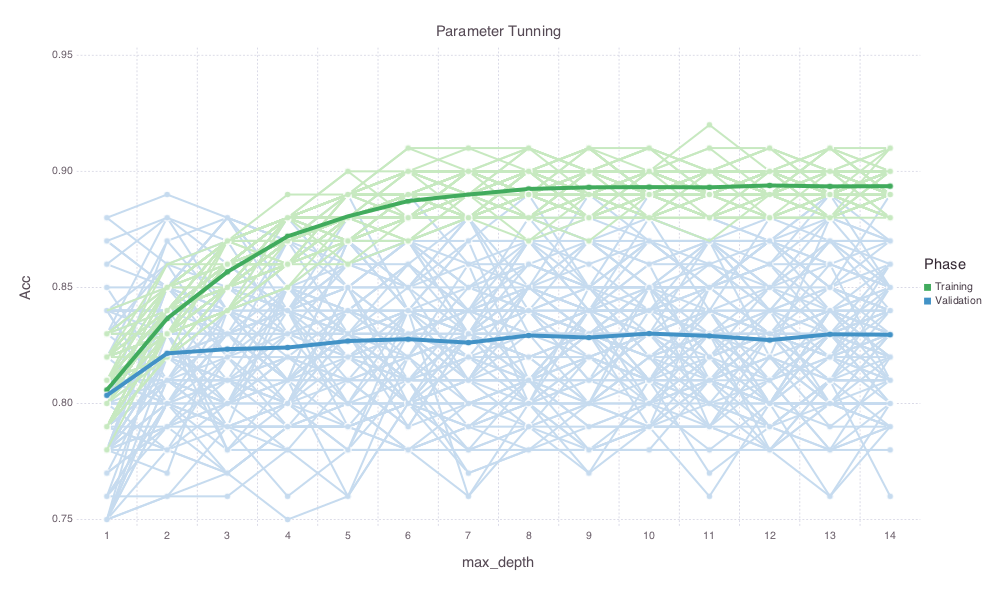

[8]	train-error:0.098177
[9]	train-error:0.099579
[10]	train-error:0.096774


In [248]:
num_rounds = 10; key = "max_depth"; values = [1:14]
tunning_param_ntimes(train, features, label, num_rounds, params, key, values, 100)

## Prepare Submission

In [17]:
submission = DataFrame(PassengerId=test[:PassengerId], Survived=ypred_submission)
writetable("./data/prediction_v10_gradient_boosting.csv", submission);

,PassengerId,Survived
1,892,0
2,893,0
3,894,0
4,895,0
5,896,0
6,897,0
7,898,0
8,899,0
9,900,1
10,901,0


## Results Kaggle